In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

In [54]:
endpoint = 'https://min-api.cryptocompare.com/data/v2/histoday?fsym=BTC&tsym=USD&limit=500'
api_key = '2b967442562fe24c326388ed0d91d7dd9dab4fbbbcbf929bdc71e5c5fe56f9b3'
res = requests.get(endpoint + '&api_key={your_api_key}')

In [55]:
hist = pd.DataFrame(json.loads(res.content)['Data']['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'
hist.drop("conversionType", axis=1, inplace=True)
hist.drop("conversionSymbol", axis=1, inplace=True)

In [56]:
hist.head(20)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2020-10-15,11607.59,11269.05,11429.30,33044.49,3.778013e+08,11508.31
2020-10-16,11545.35,11224.89,11508.31,29300.16,3.323206e+08,11326.25
2020-10-17,11410.01,11270.69,11326.25,9901.25,1.123061e+08,11367.65
2020-10-18,11513.68,11357.25,11367.65,11528.41,1.318866e+08,11513.33
2020-10-19,11821.95,11417.11,11513.33,39224.67,4.564046e+08,11756.88
2020-10-20,12047.73,11688.39,11756.88,48504.61,5.761281e+08,11921.78
2020-10-21,13236.39,11900.51,11921.78,103080.18,1.296153e+09,12813.11
2020-10-22,13197.69,12700.74,12813.11,57124.85,7.395910e+08,12990.25
2020-10-23,13031.82,12732.62,12990.25,32269.84,4.166629e+08,12937.20


In [57]:
def train_test_split(df, test_size):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [58]:
train_data, test_data= train_test_split(hist, 0.2) #train,test,val - 0.6,0.2,0.2

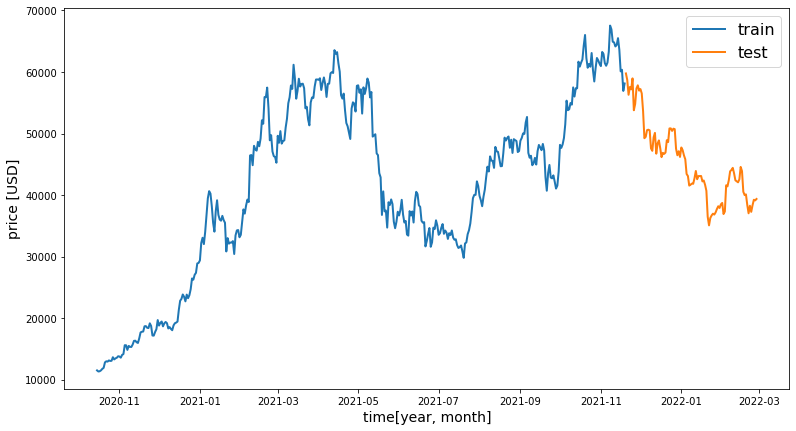

In [59]:
def line_plot(line1, line2, label1='train', label2='test',title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_xlabel('time[year, month]', fontsize=14)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
line_plot(train_data[target_col], test_data[target_col], 'train', 'test', title='')


In [60]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [61]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)
#print(extract_window_data(hist, 10, True))


In [62]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    Y_train = train_data[target_col][window_len:].values
    Y_test = test_data[target_col][window_len:].values
    if zero_base:
        Y_train = Y_train / train_data[target_col][:-window_len].values - 1
        Y_test = Y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, Y_train, Y_test

In [63]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [64]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [65]:
train, test, X_train, X_test, Y_train, Y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [66]:
input_shape=(X_train.shape[1], X_train.shape[2])
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

In [67]:
history = model.fit(
    X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 1s 2ms/step - loss: 0.0087
Epoch 2/20
13/13 [==============================] - 0s 2ms/step - loss: 0.0061
Epoch 3/20
13/13 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 4/20
13/13 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 5/20
13/13 [==============================] - 0s 2ms/step - loss: 0.0040
Epoch 6/20
13/13 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 7/20
13/13 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 8/20
13/13 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 9/20
13/13 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 10/20
13/13 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 11/20
13/13 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 12/20
13/13 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 13/20
13/13 [==============================

In [68]:
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, Y_test)

0.029404931239276167

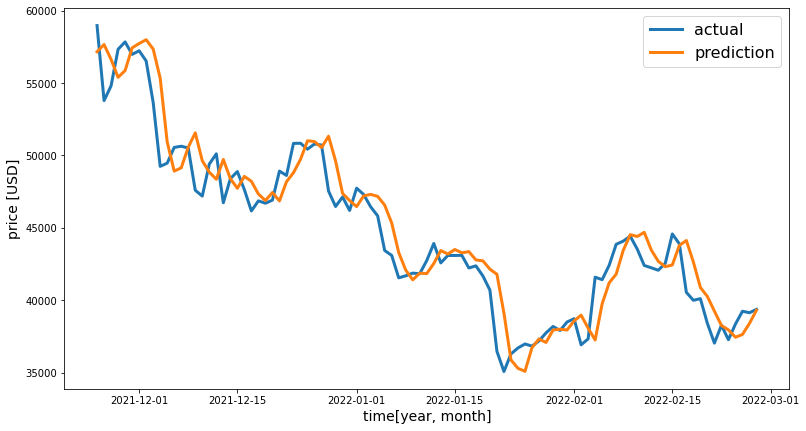

In [69]:
targets = test[target_col][window_len:]
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

#print(targets)
#print(preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [72]:
#sample prediction
x = "2022-03-01"
y = pd.to_datetime(x)
print(y)

2022-03-01 00:00:00
